## Classifier Analysis

### Naive Bayesian Classifier

The purpose of this Naive Bayesian Classifier is to sort tackles into "successful" vs. "unsuccessful" based on the combination of player attributes associated with it.

**Resources Used**
- https://www.datacamp.com/tutorial/naive-bayes-scikit-learn
- https://scikit-learn.org/1.5/modules/naive_bayes.html
- https://deebuls.github.io/Naive-Bayes-Pandas.html

In [11]:
# Importing packages for analysis
import pandas as pd
import numpy as np

# Specific to Bayes classifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    accuracy_score,
    f1_score
)

In [12]:
# Importing data provided by NFL Kaggle dataset
tackles = pd.read_csv("../data/tackles.csv")
plays = pd.read_csv("../data/plays.csv")
games = pd.read_csv("../data/games.csv")
players = pd.read_csv("../data/players.csv")

# Display
print("\nTackles")
display(tackles.head())
print("\nPlays")
display(plays.head())
# print("\nGames")
# display(games.head())
print("\nPlayers")
display(players.head())


Tackles


,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0
1,2022090800,393,46232,1,0,0,0
2,2022090800,486,40166,1,0,0,0
3,2022090800,646,47939,1,0,0,0
4,2022090800,818,40107,1,0,0,0



Plays


,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,0.620552,0.379448,-0.002451,0.002451,1.641006,-0.043580,NaN,NaN,NaN,NaN
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,0.836290,0.163710,0.001053,-0.001053,3.686428,-0.167903,NaN,NaN,NaN,NaN



Players


,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [13]:
# Data cleaning to get ready for Bayes classifier

# Merging tables
attributed_tackles = tackles.merge(plays, left_on='playId', right_on='playId')
attributed_tackles = attributed_tackles.merge(players, left_on='ballCarrierId', right_on='nflId')

# Subset to focus on player attributes
attributed_tackles = attributed_tackles[['playId', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle',
                                         'ballCarrierId', 'ballCarrierDisplayName', 'height', 'weight',
                                         'position']]

# Creating column for "true tackles", because:
# In addition to basic tackles (marked as 'tackle'==1),
# those marked as 'assist'==1 and 'tackle'==0
# are actually tackles as well.
attributed_tackles['trueTackle'] = np.where((attributed_tackles['tackle'] == 1) |
                                            ((attributed_tackles['assist'] == 1) &
                                             (attributed_tackles['tackle'] == 0)),
                                             1, 0)

# Viewing distribution of height/weight values
attributed_tackles['weight'].min() # 153
attributed_tackles['weight'].max() # 311

attributed_tackles['height'].value_counts()
# 5-10    14799
# 5-11    11292
# 6-1      9202
# 6-0      7968
# 6-2      7043
# 6-3      5685
# 6-4      4714
# 5-9      4080
# 6-5      4078
# 5-8      2115
# 6-6      1521
# 5-7       766
# 5-6       151
# 6-7        82
# 6-8        70

# Dividing height into feet / inches for easier sorting
attributed_tackles[['heightFeet', 'heightInches']] = attributed_tackles.height.str.split('-', expand=True)
attributed_tackles

# Bucketing 'height' into categories
height_sorting_conditions = [(pd.to_numeric(attributed_tackles['heightFeet']) == 6) & (pd.to_numeric(attributed_tackles['heightInches']) > 2),
                             (pd.to_numeric(attributed_tackles['heightFeet']) == 6) & (pd.to_numeric(attributed_tackles['heightInches']) <= 2),
                             (pd.to_numeric(attributed_tackles['heightFeet']) == 5) & (pd.to_numeric(attributed_tackles['heightInches']) >= 10),
                             (pd.to_numeric(attributed_tackles['heightFeet']) == 5) & (pd.to_numeric(attributed_tackles['heightInches']) < 10)]
height_sorting_values = ['Tall', 'Average', 'Average', 'Short']
attributed_tackles['heightCategory'] = np.select(height_sorting_conditions, height_sorting_values, default = "")

# Bucketing 'weight' into categories
weight_sorting_conditions = [(pd.to_numeric(attributed_tackles['weight']) < 200),
                             (pd.to_numeric(attributed_tackles['weight']) >= 200) & (pd.to_numeric(attributed_tackles['weight']) <= 250),
                             (pd.to_numeric(attributed_tackles['weight']) > 250)]
weight_sorting_values = ['Under 200', '200 - 250', 'Over 250']
attributed_tackles['weightCategory'] = np.select(weight_sorting_conditions, weight_sorting_values, default = "")

attributed_tackles

,playId,tackle,assist,forcedFumble,pff_missedTackle,ballCarrierId,ballCarrierDisplayName,height,weight,position,trueTackle,heightFeet,heightInches,heightCategory,weightCategory
0,101,1,0,0,0,39975,Cordarrelle Patterson,6-2,238,RB,1,6,2,Average,200 - 250
1,101,1,0,0,0,39975,Cordarrelle Patterson,6-2,238,RB,1,6,2,Average,200 - 250
2,101,1,0,0,0,39975,Cordarrelle Patterson,6-2,238,RB,1,6,2,Average,200 - 250
3,101,1,0,0,0,39975,Cordarrelle Patterson,6-2,238,RB,1,6,2,Average,200 - 250
4,101,1,0,0,0,39975,Cordarrelle Patterson,6-2,238,RB,1,6,2,Average,200 - 250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73561,3229,1,0,0,0,53638,Jalen Camp,6-2,220,WR,1,6,2,Average,200 - 250
73562,3229,0,1,0,0,53638,Jalen Camp,6-2,220,WR,1,6,2,Average,200 - 250
73563,3229,0,1,0,0,53638,Jalen Camp,6-2,220,WR,1,6,2,Average,200 - 250
73564,3229,0,1,0,0,53638,Jalen Camp,6-2,220,WR,1,6,2,Average,200 - 250


In [14]:
final_subset = attributed_tackles[['trueTackle',
                                   'position', 'heightCategory', 'weightCategory']]
tree_final_subset = final_subset
final_subset = pd.get_dummies(final_subset, columns=['position', 'heightCategory', 'weightCategory'])

# Bayes Classifier

x = final_subset.drop('trueTackle', axis=1)
y = final_subset['trueTackle']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=125
)

bayes_model = BernoulliNB()
bayes_model.fit(x_train, y_train)

y_pred_bayes = bayes_model.predict(x_test)

accuracy_bayes = accuracy_score(y_pred_bayes, y_test)
f1_bayes = f1_score(y_pred_bayes, y_test, average="weighted")

print("Accuracy:", accuracy_bayes)
print("F1 Score:", f1_bayes)

# Probability of a tackle given position RB, average height, and weight between 200 and 250 pounds
sample_pred_1 = {'position_FB': [0], 'position_QB': [0], 'position_RB': [1],
                 'position_TE': [0], 'position_WR': [0],
                 'heightCategory_Average': [1], 'heightCategory_Short': [0], 'heightCategory_Tall': [0],
                 'weightCategory_200 - 250': [1], 'weightCategory_Over 250': [0],
                 'weightCategory_Under 200': [0]}
sample_pred_df_1 = pd.DataFrame(data=sample_pred_1)
print("\nSample Prediction 1:", bayes_model.predict(sample_pred_df_1))

# Probability of a tackle given position QB, tall height, and weight over 250 pounds
sample_pred_2 = {'position_FB': [0], 'position_QB': [1], 'position_RB': [0],
                 'position_TE': [0], 'position_WR': [0],
                 'heightCategory_Average': [0], 'heightCategory_Short': [0], 'heightCategory_Tall': [1],
                 'weightCategory_200 - 250': [0], 'weightCategory_Over 250': [1],
                 'weightCategory_Under 200': [0]}
sample_pred_df_2 = pd.DataFrame(data=sample_pred_2)
print("Sample Prediction 2:", bayes_model.predict(sample_pred_df_2))

Accuracy: 0.8863945298018701
F1 Score: 0.9397763996855621

Sample Prediction 1: [1]
Sample Prediction 2: [1]


### Decision Tree Classifier

This Decision Tree Classifier has the same goal and uses the same attributes as the Bayes Classifier above.

**Resources Used:**
- https://medium.com/@ompramod9921/decision-trees-6a3c05e9cb82

c:\Users\rubba\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


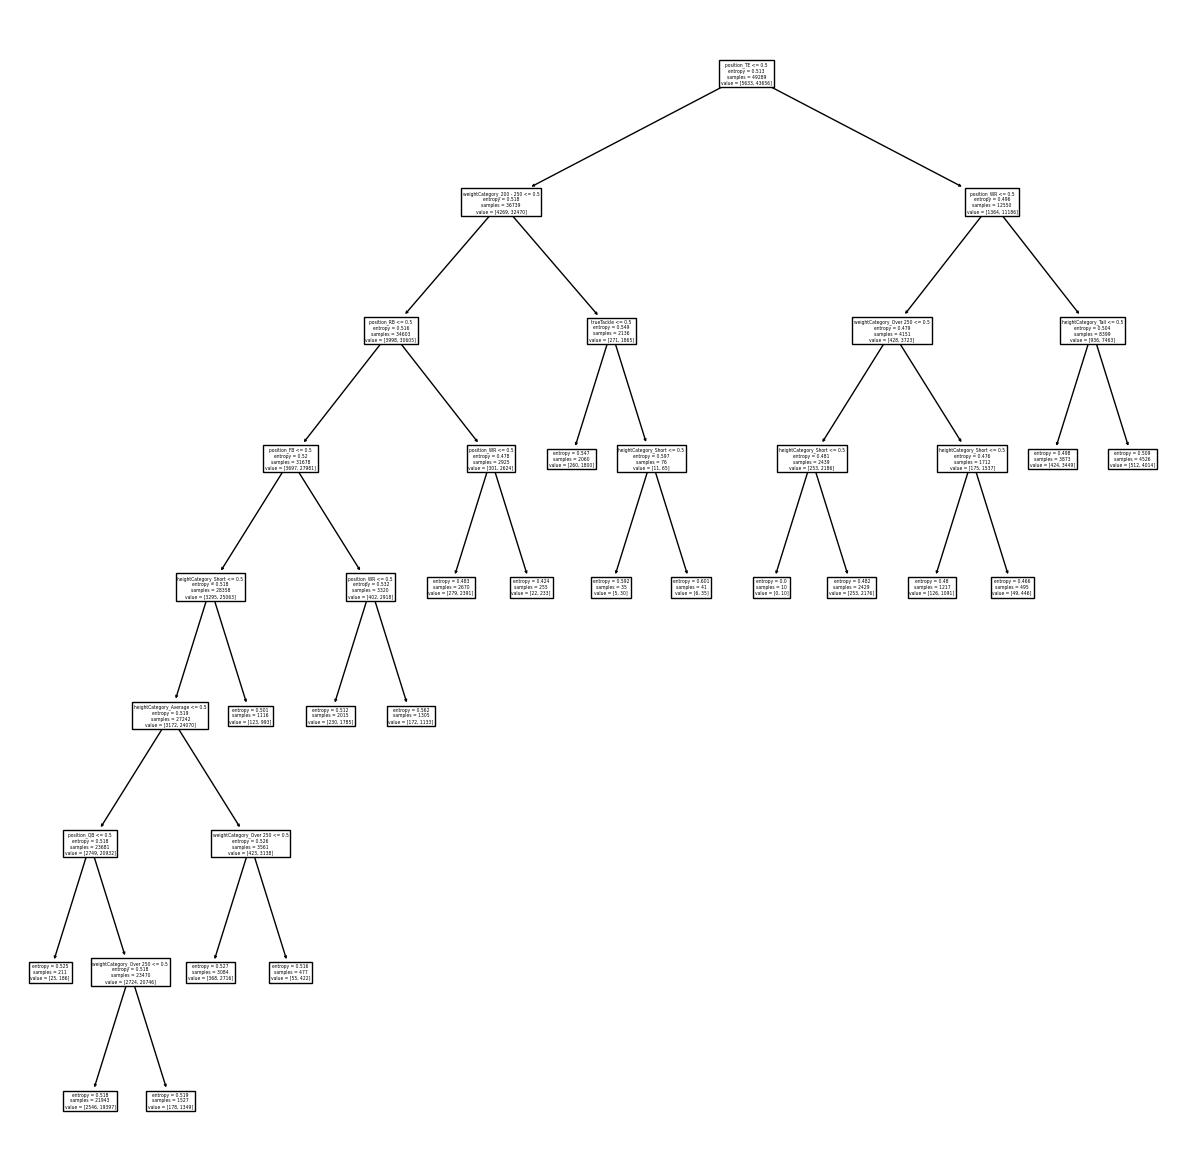

In [15]:
from sklearn import tree
from matplotlib import pyplot as plt

tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4)
tree_model.fit(x_train.values, y_train)

y_pred_tree = tree_model.predict(x_test)

fig, ax = plt.subplots(figsize=(15, 15))
tree.plot_tree(tree_model, ax=ax, feature_names=['trueTackle', 'position_FB', 'position_QB',
                                                 'position_RB', 'position_TE', 'position_WR',
                                                 'heightCategory_Average', 'heightCategory_Short',
                                                 'heightCategory_Tall', 'weightCategory_200 - 250',
                                                 'weightCategory_Over 250', 'weightCategory_Under 200'])
plt.show()

In [16]:
accuracy_tree = accuracy_score(y_pred_tree, y_test)
f1_tree = f1_score(y_pred_tree, y_test, average="weighted")

print("Accuracy:", accuracy_tree)
print("F1 Score:", f1_tree)

# Probability of a tackle given position RB, average height, and weight between 200 and 250 pounds
print("\nSample Prediction 1:", tree_model.predict([[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]]))

# Probability of a tackle given position QB, tall height, and weight over 250 pounds
print("Sample Prediction 2:", tree_model.predict([[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]]))


Accuracy: 0.8863945298018701
F1 Score: 0.9397763996855621

Sample Prediction 1: [1]
Sample Prediction 2: [1]


### Conclusions

This Bayes Classifier is shown to have about 88.6% accuracy for predicting the success/failure of a tackle based on attributes of the ball carrier (the player being tackled), such as position, height, and weight.

Meanwhile, a Decision Tree of the same attributes also has the same accuracy and returns comparable predictive values, but is unwieldy as a visual representation.

However, because of limitations with the tackles dataset provided (namely, that relatively few missed tackles are provided in comparison to successful tackles), more exploration is likely necessary to determine if a classifier with such attributes is effective.

### Justifications

The attributes used in the Bayesian and Decision Tree classifiers were chosen for their relation to physical player qualities in addition to their roles within the game. We wanted to explore whether or not certain positions were more likely to be tackled, as well as whether or not the physical qualities of a player were related to their rate of being tackled.

Player `height` and `weight` were the only attributes available related to physical player qualities, and `position` was, of course, used to understand player position.